# Transpilation 

## Backend Creation

In ```/src/clonk/backend_utils/mock_backends```, target topologies are created by implementing ```ConfigurableFakeBackendV2``` which is an abstract class defined in ```src/clonk/backend_utils/configurable_backend_v2.py```

In [1]:
from src.clonk.backend_utils.topology_visualization import pretty_print
from src.clonk.backend_utils.mock_backends import FakeModular

pb = FakeModular(module_size=5, children=4, total_levels=2)
pretty_print(pb)

ImportError: cannot import name 'FakeModular' from 'src.clonk.backend_utils.mock_backends' (/home/jones1/Source/clonk_transpilation/src/clonk/backend_utils/mock_backends/__init__.py)

## Decomposition Transpiler Pass
The pass manager for data collection is defined in ```/src/clonk/utils/transpiler_passes/pass_manager_v3.py```, which needs additional decomposition passes for $\sqrt{\texttt{iSwap}}$ and $\texttt{SYC}$ gates. Next, we test the $\sqrt{\texttt{iSwap}}$ pass by showing that it's Haar score tends to 2.21 as expected

In [ ]:
from qiskit.quantum_info.random import random_unitary
from qiskit import QuantumCircuit
from src.clonk.utils.riswap_gates.riswap import RiSwapGate
from src.clonk.utils.transpiler_passes.weyl_decompose import RootiSwapWeylDecomposition
from qiskit.transpiler.passes import CountOps
from qiskit.transpiler import PassManager
from tqdm import tqdm

N = 2000
basis_gate = RiSwapGate(0.5)

pm0 = PassManager()
pm0.append(RootiSwapWeylDecomposition(basis_gate=basis_gate))
pm0.append(CountOps())

res = 0
for _ in tqdm(range(N)):
    qc = QuantumCircuit(2)
    qc.append(random_unitary(dims=4), [0, 1])
    pm0.run(qc)
    res += pm0.property_set["count_ops"]["riswap"]
print("Haar score:", res / N)

100%|██████████| 2000/2000 [00:10<00:00, 189.84it/s]

Haar score: 2.1925


## Creating a Benchmark
We need to define the circuits, circuit sizes, topologies, and basis gates we want to transpile to and plot results for. We do this by wrapping the backend object and its transpiler pass manager into an object that handles data collection in ```src/clonk/benchmark_suite/backend_suite_v3.py```. The set used for data collection in the paper are in ```src/clonk/benchmark_suite/backend_suite_v2.py```. The relevant change is that 'v3' uses a slightly more optimized pass manager (optimized for time). To reproduce the results we include the `v2` versions which can regenerate the data from scratch by setting the `overwrite` parameter

In [3]:
from src.clonk.benchmark_suite.backend_suite_v3 import simple_backends_v3

print([backend.label for backend in simple_backends_v3])

ImportError: cannot import name 'level_1_pass_manager' from 'src.clonk.utils.transpiler_passes' (/home/jones1/Source/clonk_transpilation/src/clonk/utils/transpiler_passes/__init__.py)

Note: We make a modification in Supermarq for the efficient generation of QAOA circuits that eliminates the need to optimize the 1Q gate parameters, but will not effect our results. To fix in interim, comment out ```supermarq/benchmarks/qaoa_vanilla_proxy.py```, line 40 and replace with:
```python 
#self.params = self._gen_angles()
self.params = np.random.uniform(size=2) * 2 * np.pi
```

In [3]:
from src.clonk.benchmark_suite.circuit_suite import circuits

q_size = 4
circuits["QAOA_Vanilla"].circuit_lambda(q_size).decompose().draw()

global phase: 3.757
      ┌─────────┐                                                    »
 q_0: ┤ U2(0,π) ├──■─────────────────■────■──────────────────■────■──»
      ├─────────┤┌─┴─┐┌───────────┐┌─┴─┐  │                  │    │  »
 q_1: ┤ U2(0,π) ├┤ X ├┤ U1(3.757) ├┤ X ├──┼──────────────────┼────┼──»
      ├─────────┤└───┘└───────────┘└───┘┌─┴─┐┌────────────┐┌─┴─┐  │  »
 q_2: ┤ U2(0,π) ├───────────────────────┤ X ├┤ U1(-3.757) ├┤ X ├──┼──»
      ├─────────┤                       └───┘└────────────┘└───┘┌─┴─┐»
 q_3: ┤ U2(0,π) ├───────────────────────────────────────────────┤ X ├»
      └─────────┘                                               └───┘»
m0: 4/═══════════════════════════════════════════════════════════════»
                                                                     »
«                         ┌────────────┐             ┌─┐          »
« q_0: ────────────────■──┤ R(10.21,0) ├─────────────┤M├──────────»
«                      │  └────────────┘             └╥┘          »
« q_1: ────────────────┼────────■─────────────────────╫───■───────»
«                      │        │                     ║   │       »
« q_2: ────────────────┼────────┼─────────────────────╫───┼────■──»
«      ┌────────────┐┌─┴─┐    ┌─┴─┐     ┌───────────┐ ║ ┌─┴─┐┌─┴─┐»
« q_3: ┤ U1(-3.757) ├┤ X ├────┤ X ├─────┤ U1(3.757) ├─╫─┤ X ├┤ X ├»
«      └────────────┘└───┘    └───┘     └───────────┘ ║ └───┘└───┘»
«m0: 4/═══════════════════════════════════════════════╩═══════════»
«                                                     0           »
«                                                                              
« q_0: ────────────────────────────────────────────────────────────────────────
«                                                          ┌────────────┐┌─┐   
« q_1: ─────────────────────────■───────────────────────■──┤ R(10.21,0) ├┤M├───
«                             ┌─┴─┐     ┌────────────┐┌─┴─┐├────────────┤└╥┘┌─┐
« q_2: ────────────────■──────┤ X ├─────┤ U1(-3.757) ├┤ X ├┤ R(10.21,0) ├─╫─┤M├
«      ┌────────────┐┌─┴─┐┌───┴───┴────┐└────┬─┬─────┘└───┘└────────────┘ ║ └╥┘
« q_3: ┤ U1(-3.757) ├┤ X ├┤ R(10.21,0) ├─────┤M├──────────────────────────╫──╫─
«      └────────────┘└───┘└────────────┘     └╥┘                          ║  ║ 
«m0: 4/═══════════════════════════════════════╩═══════════════════════════╩══╩═
«                                             3                           1  2

Starting benchmark for Quantum_Volume
Starting benchmark for QFT
Starting benchmark for QAOA_Vanilla
Starting benchmark for TIM_Hamiltonian
Starting benchmark for Adder
Starting benchmark for GHZ


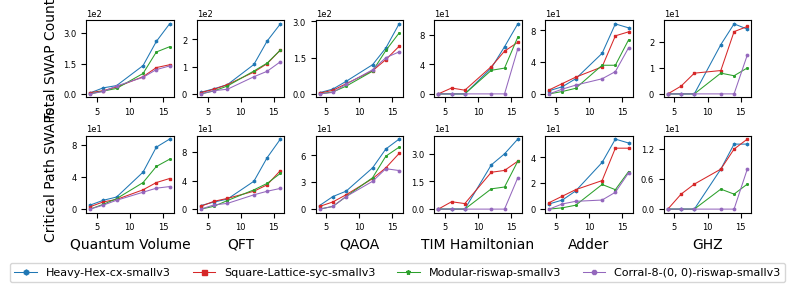

In [4]:
"""Example:"""

from src.clonk.benchmark_suite.main_plotting import benchmark, plot_wrap

for circuit_gen in circuits.values():
    benchmark(
        backends=simple_backends_v3,
        circuit_generator=circuit_gen,
        q_range=[4, 6, 8, 12, 14, 16],
        continuously_save=1,
        overwrite=0,  # NOTE: turn this to 1 if you want to scrap the saved data and recollect a new batch
        repeat=1,
    )

# NOTE when plotting use motivation = 1 to plot SWAP counts, and motivation = 0 to plot gate durations
plot_wrap(simple_backends_v3, circuits.keys(), motivation=True, plot_average=True)

### Paper Figures

Starting benchmark for Quantum_Volume
Starting benchmark for QFT
Starting benchmark for QAOA_Vanilla
Starting benchmark for TIM_Hamiltonian
Starting benchmark for Adder
Starting benchmark for GHZ


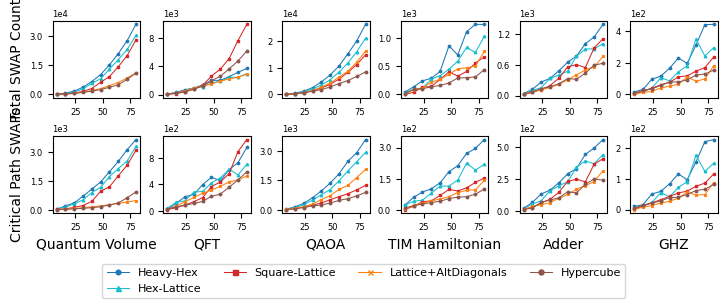

In [6]:
"""Fig 4"""
from src.clonk.benchmark_suite.backend_suite_v2 import motivation_backends

for circuit_gen in circuits.values():
    benchmark(
        backends=motivation_backends,
        circuit_generator=circuit_gen,
        q_range=motivation_backends[0].q_range,
        continuously_save=True,
        overwrite=False,
        repeat=1,
    )
plot_wrap(motivation_backends, circuits.keys(), motivation=True, plot_average=True)

Starting benchmark for Quantum_Volume
Starting benchmark for QFT
Starting benchmark for QAOA_Vanilla
Starting benchmark for TIM_Hamiltonian
Starting benchmark for Adder
Starting benchmark for GHZ


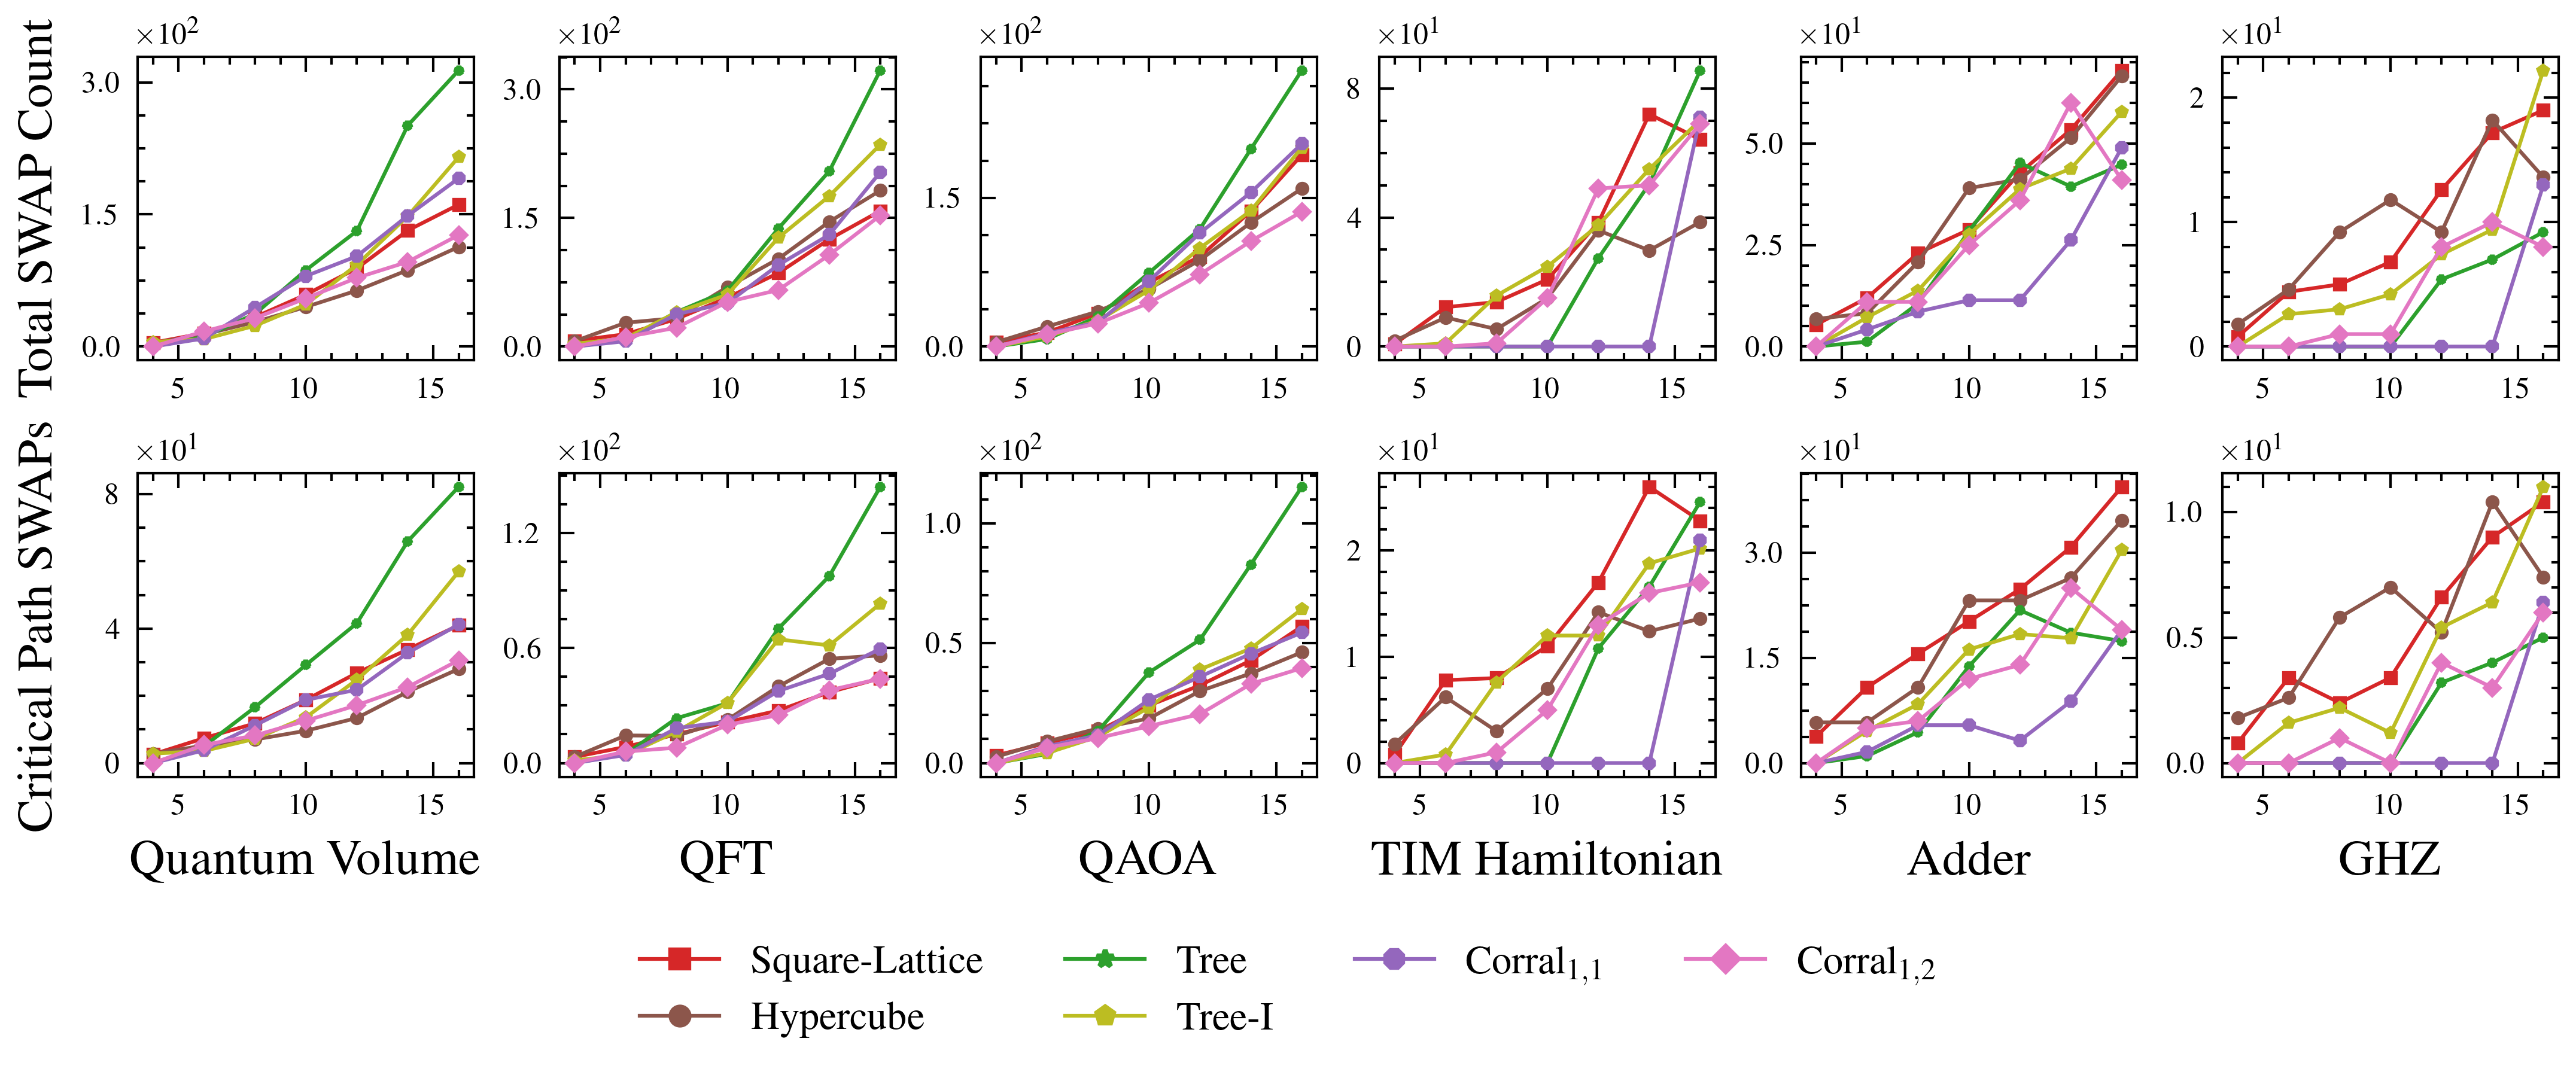

In [13]:
"""Fig 10"""
from src.clonk.benchmark_suite.backend_suite_v2 import small_results_backends

for circuit_gen in circuits.values():
    benchmark(
        backends=small_results_backends,
        circuit_generator=circuit_gen,
        q_range=small_results_backends[0].q_range,
        continuously_save=True,
        overwrite=False,
        repeat=1,
    )
plot_wrap(small_results_backends, circuits.keys(), motivation=True, plot_average=True)

Starting benchmark for Quantum_Volume
Starting benchmark for QFT
Starting benchmark for QAOA_Vanilla
Starting benchmark for TIM_Hamiltonian
Starting benchmark for Adder
Starting benchmark for GHZ


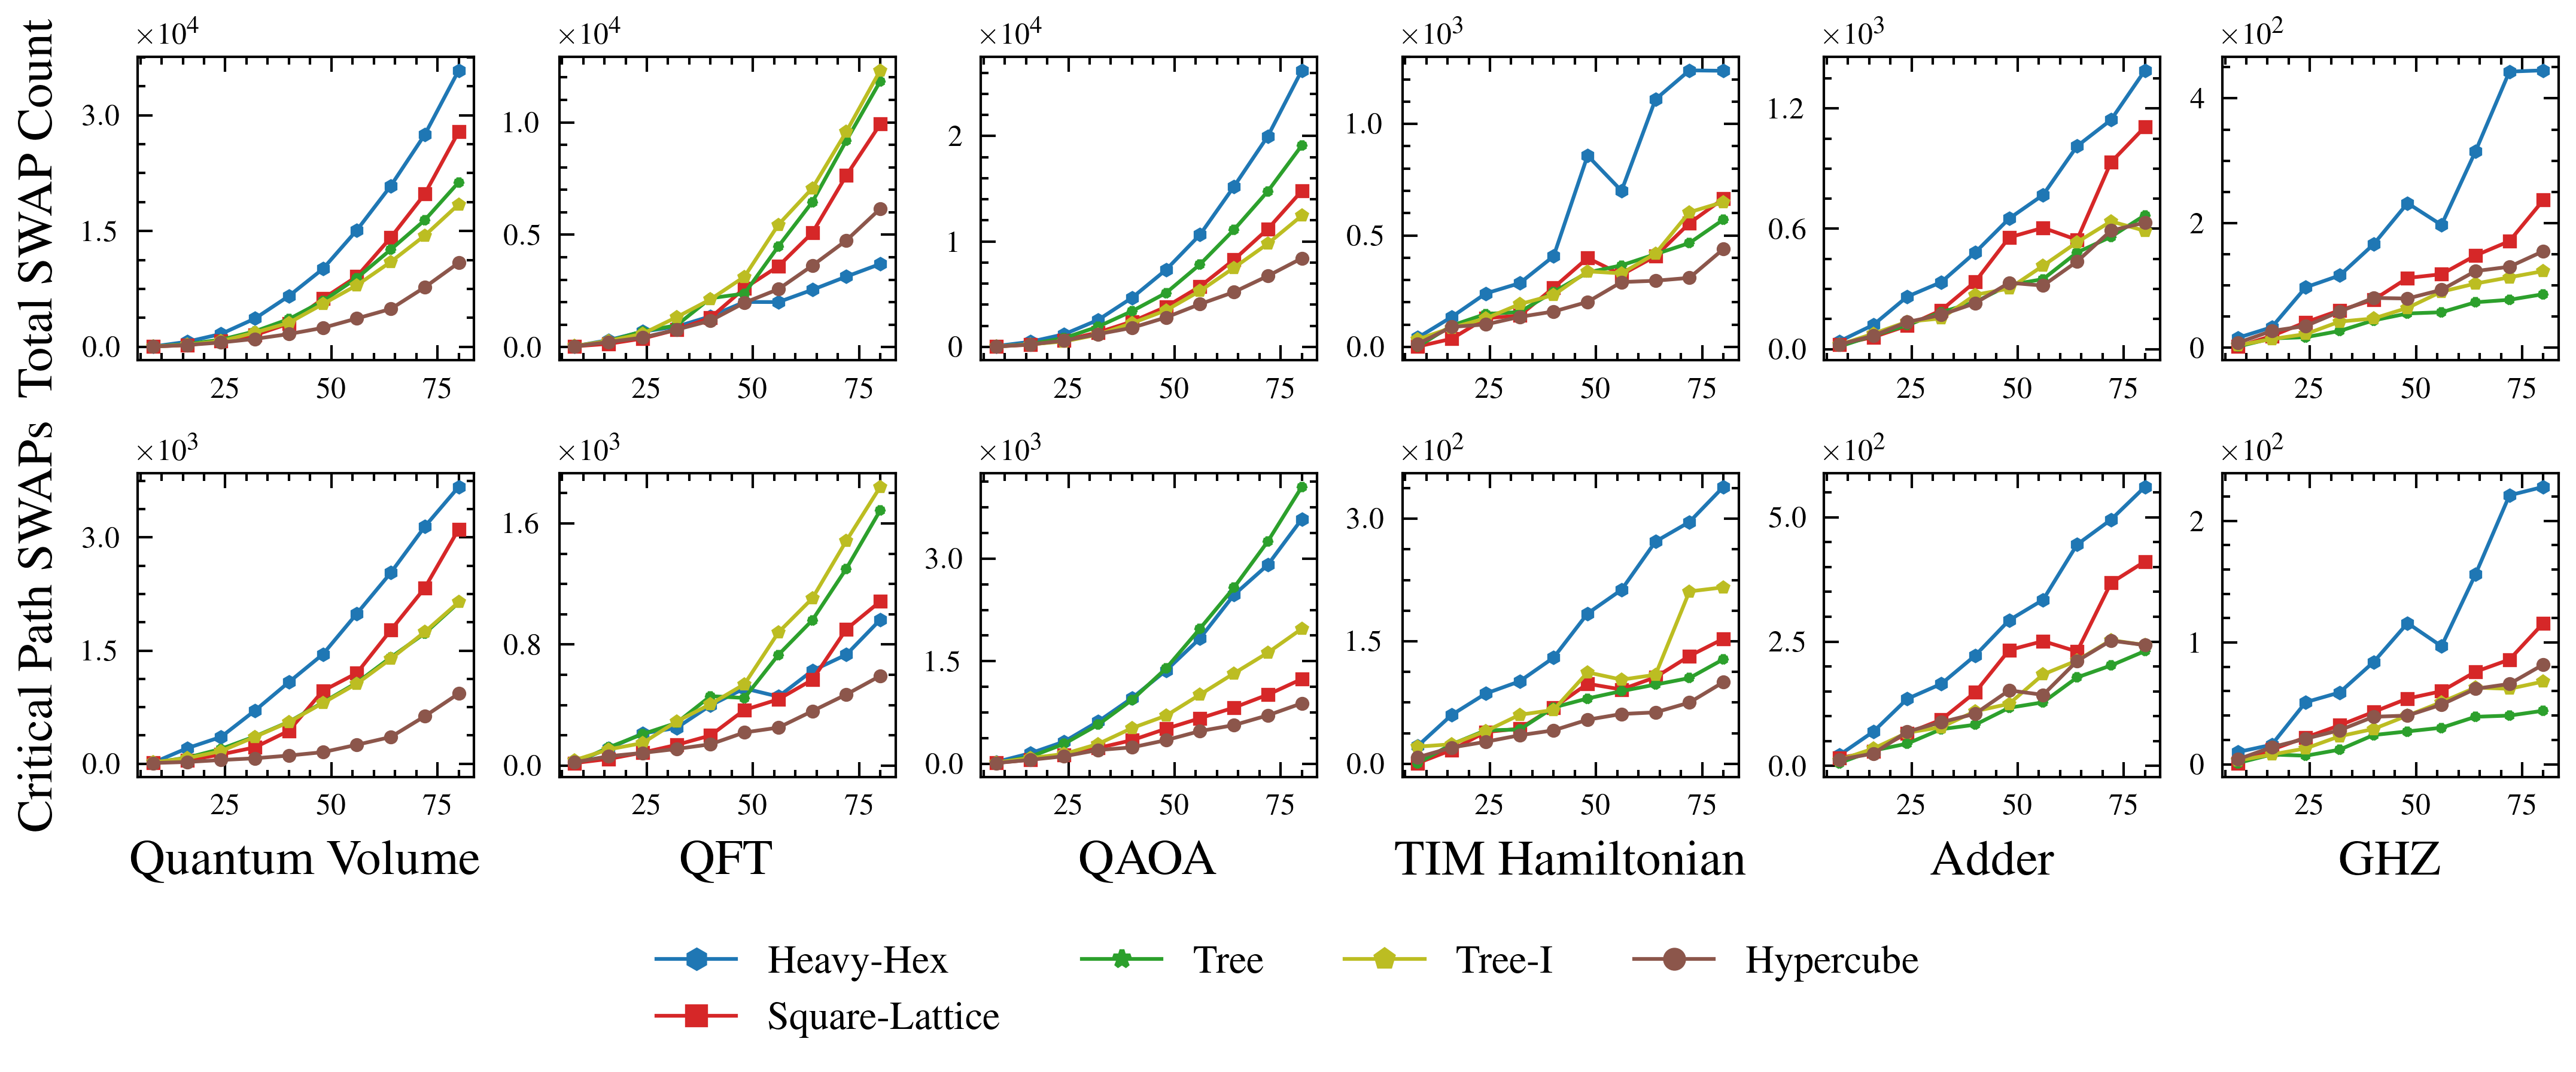

In [15]:
# """Fig 12"""
from src.clonk.benchmark_suite.backend_suite_v2 import results_backends

for circuit_gen in circuits.values():
    benchmark(
        backends=results_backends,
        circuit_generator=circuit_gen,
        q_range=results_backends[0].q_range,
        continuously_save=True,
        overwrite=False,
        repeat=1,
    )
plot_wrap(results_backends, circuits.keys(), motivation=True, plot_average=True)

In [19]:
"""Fig 13"""
from src.clonk.benchmark_suite.backend_suite_v2 import small_results_part2_backends

for circuit_gen in circuits.values():
    benchmark(
        backends=small_results_part2_backends,
        circuit_generator=circuit_gen,
        q_range=small_results_part2_backends[0].q_range,
        continuously_save=True,
        overwrite=False,
        repeat=1,
    )
plot_wrap(
    small_results_part2_backends, circuits.keys(), motivation=False, plot_average=True
)

Starting benchmark for Quantum_Volume
Starting benchmark for QFT
Starting benchmark for QAOA_Vanilla
Starting benchmark for TIM_Hamiltonian
Starting benchmark for Adder
Starting benchmark for GHZ


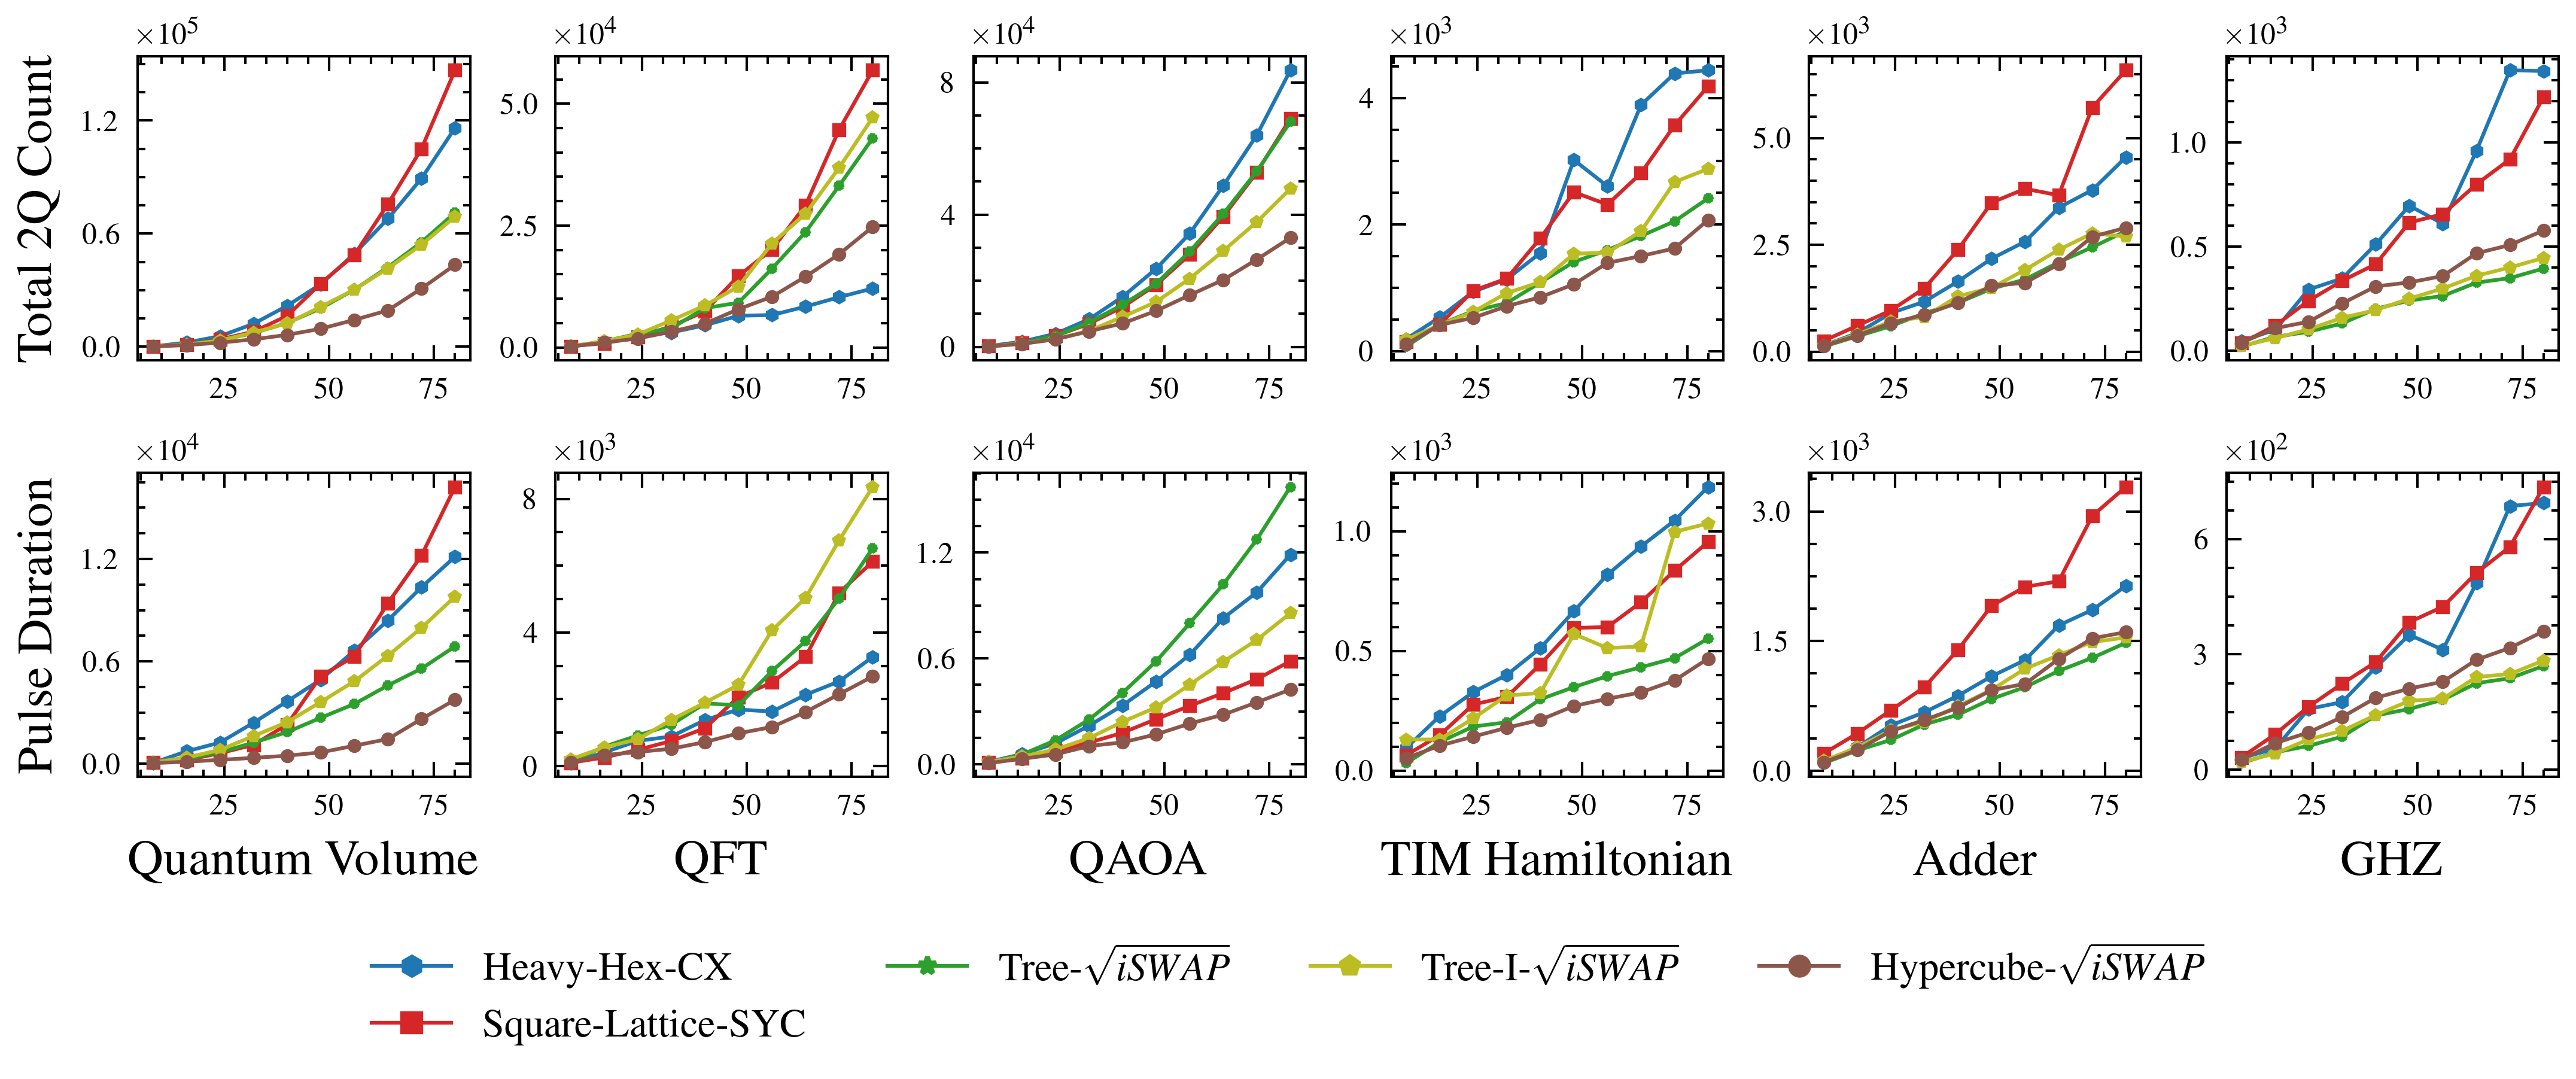

In [16]:
"""Fig 14"""
plot_wrap(results_backends, circuits.keys(), motivation=False, plot_average=True)

### Finally, we use a quick calculation which converts the transpiled circuit data into useable numbers for the fidelity models.

In [ ]:
from src.clonk.benchmark_suite.backend_suite_v2 import small_results_part2_backendsv2
from qiskit.converters import circuit_to_dag
import numpy as np

ignore = ["u"]

for circuit_gen in circuits.values():  # [circuits['Quantum_Volume']]:
    print(circuit_gen.label)
    qc = circuit_gen.circuit_lambda(16)

    for backend in small_results_part2_backendsv2:
        print(backend.label)
        c = backend.pass_manager.run(qc)  # transpile :)
        d = circuit_to_dag(c)
        w = d.qubits  # if use wires error bc returns classical bits

        qubit_wire_counts = np.zeros(20)
        for i, wi in enumerate(w):
            for node in d.nodes_on_wire(wi, only_ops=True):
                if node.name in ignore:
                    continue
                # count the 2Q ops
                if node.name in ["cx", "fSim", "riswap"]:
                    qubit_wire_counts[i] += 1

        # print(qubit_wire_counts)
        print(sum(qubit_wire_counts))

# Approximate Decomposition

Need to have cloned this fork https://github.com/evmckinney9/NuOp to function. Since it is not packaged, I put it in a directory called external to make the imports inside ```nuop_script.py work```. 

In [1]:
from src.clonk.benchmark_suite.nuop_script import create_plot2, collect_random2q_data

In [2]:
N = 20
base_fidelity_list = [0.97, 0.98, 1 - 10e-3, 1 - 5e-3, 1 - 10e-4, 1]
filename = f"src/clonk/benchmark_suite/data-archive2/data1_random.h5"  # NOTE preloaded, change name of file to recollect
gate_error, decomp_error, fidelity_error = collect_random2q_data(
    1 - 10e-3, N=N, mode="random", fn=filename
)

0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


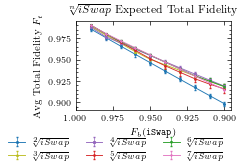

In [4]:
create_plot2(gate_error, decomp_error, fidelity_error, plot_bool=0, fn=filename);

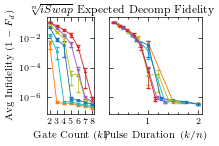

In [5]:
create_plot2(gate_error, decomp_error, fidelity_error, plot_bool=1, fn=filename);